# Imports

In [5]:
try:
  import iminuit
  from iminuit import Minuit
  from iminuit.cost import LeastSquares, UnbinnedNLL, BinnedNLL, ExtendedUnbinnedNLL
except:
  Exception('Error Initialising Iminuit')

In [6]:
import os
from IPython.display import Latex
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from funcs import *
from stats import *

# funcs

# Calcolo

In [88]:
def analize(path, init=0):
    RES, SIG, MTH = get_data(path)
    N = init
    max_res, i_max_res = find_max(RES[1], N, prec=0.00001)
    max_sig, i_max_sig = find_max(SIG[1], N, prec=0.00001)
    zero_res, i_zero_res = find_zero(RES[1], N, prec=0.00001)
    zero_sig, i_zero_sig = find_zero(SIG[1], N, prec=0.00001)

    return max_res/max_sig, np.abs(RES[0][i_zero_res]- SIG[0][i_zero_sig])


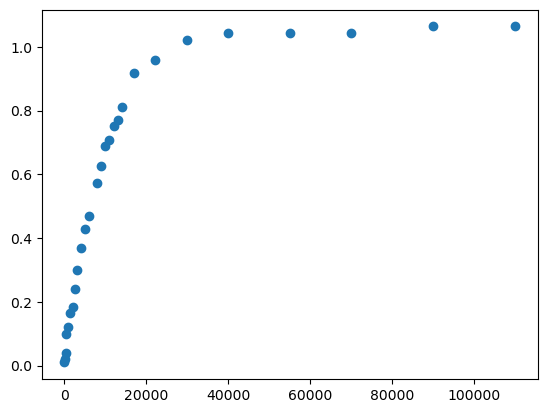

In [114]:
mods, fases, freqs = [], [], []

for i in os.listdir('data/RC'):
    path = 'data/RC/'+i+'/'
    mod, fase = analize(path, 300)
    mods.append(mod)
    fases.append(fase)
    freqs.append(float(i))
mods.pop()
fases.pop()
freqs.pop()
plt.scatter(freqs,mods)

In [133]:
def H_R(w,R,C, a):
    return w*R*C/np.sqrt(1+(w**2 * R**2 * C**2)) + a

In [134]:
c = LeastSquares(freqs, mods,0.05, H_R)
m = Minuit(c, R=1000, C=12e-9, a=0)
m.migrad()
m.minos()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6.908 (χ²/ndof = 0.3)      │             Nfcn = 1978              │
│ EDM = 3.48e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │    3e3    │    9e3    │    -6e3    │    6e3     │         │         │       │
│ 1 │ C    │  0.03e-6  │  0.10e-6  │  -0.08e-6  │  0.08e-6   │         │         │       │
│ 2 │ a    │   0.052   │   0.016   │   -0.016   │   0.016    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │           R           │           C           │           a           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -6e3    │    6e3    │ -0.08e-6  │  0.08e-6  │  -0.016   │   0.016   │
│  Valid   │   False   │   False   │   False   │   False   │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───┬───────────────────────────────────────────────────────┐
│   │                 R                 C                 a │
├───┼───────────────────────────────────────────────────────┤
│ R │          7.48e+07 -897.604478855e-6          -1.06570 │
│ C │ -897.604478855e-6          1.08e-14       -12.754e-12 │
│ a │          -1.06570       -12.754e-12          0.000249 │
└───┴───────────────────────────────────────────────────────┘

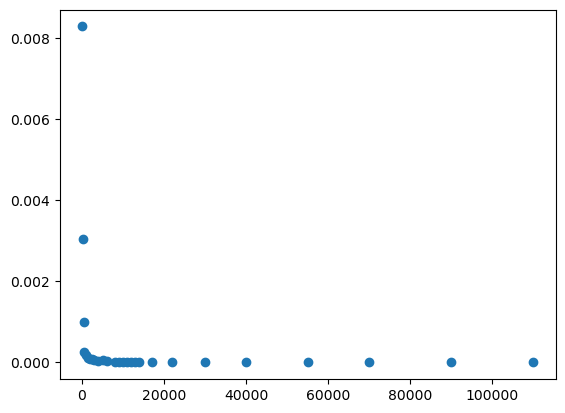

In [108]:
plt.scatter(freqs,fases)

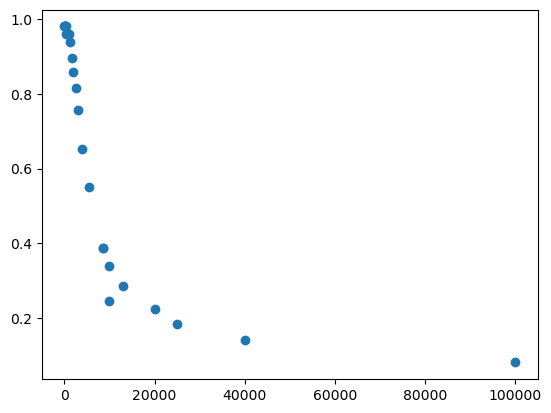

In [109]:
mods, fases, freqs = [], [], []

for i in os.listdir('data/RL'):
    path = 'data/RL/'+i+'/'
    mod, fase = analize(path, 300)
    mods.append(mod)
    fases.append(fase)
    freqs.append(float(i))

mods.pop()
fases.pop()
freqs.pop()
plt.scatter(freqs,mods)

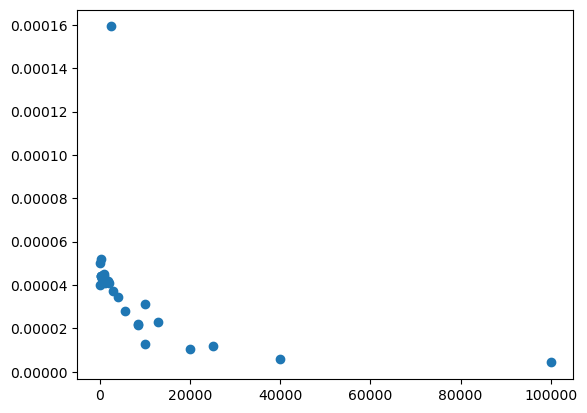

In [110]:
plt.scatter(freqs,fases)